In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import pickle
import statsmodels.api as sm
from sklearn import cross_validation, datasets, grid_search, ensemble, tree, cluster, pipeline, manifold, preprocessing, feature_selection, decomposition
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin
from treeinterpreter import treeinterpreter as ti
%matplotlib inline

In [100]:
df = pd.read_csv('mojo1516.csv')

In [101]:
df['Datetime'] = pd.to_datetime(df['ReleaseDate'])

In [102]:
df = df.drop(df[df.Datetime < datetime(2015, 8, 1, 0, 0)].index)
df = df.drop(df[df.Datetime > datetime(2016, 8, 1, 0, 0)].index)

In [103]:
df.to_csv('mojo_c.csv')

In [104]:
movie_wiki = pickle.load(open("wikiviews.p","rb"))

In [105]:
pageviews = []
for k, v in movie_wiki.items():
    pageviews.append((k,v[0]))

In [106]:
df_wiki = pd.DataFrame(pageviews, columns=['Title', 'Wikiviews'])

In [107]:
df = df.sort_values(by='Title')
df = df.reset_index()
df_wiki = df_wiki.sort_values(by='Title')
df_wiki = df_wiki.reset_index()
df['Wikiviews'] = df_wiki['Wikiviews']

In [108]:
months = df.Datetime.map(lambda x: x.strftime('%m'))
df['Quarter'] = months.map({'01':'Q1', '02':'Q1', '03':'Q1', '04':'Q2', '05':'Q2', '06':'Q2', '07':'Q3', '08':'Q3', '09':'Q3', '10':'Q4', '11':'Q4', '12':'Q4'})
df = df.join(pd.get_dummies(df['Rating'], prefix='is')).join(pd.get_dummies(df['Quarter'], prefix='is'))
try:
    df.drop(['is_Unknown'], axis=1, inplace=True)
except:
    pass
df = df.join(pd.get_dummies(df['Genre'], prefix='is'))
try:
    df.drop(['is_Unknown'], axis=1, inplace=True)
except:
    pass
df1 = df
df = df.join(pd.get_dummies(df['Studio'], prefix='is'))
try:
    df.drop(['is_Unknown'], axis=1, inplace=True)
except:
    pass
df['TheaterNum'] = df['TheaterCount']
df['RunTime'] = df['Runtime']
df['Wikicount'] = df['Wikiviews']
#df['Bget'] = df['Budget']
df.drop(['index','Rating','TheaterCount','Rank','ReleaseDate','Studio','Genre','Runtime','Datetime','Wikiviews','Quarter'], axis=1, inplace=True)
df.drop(['Budget'], axis=1, inplace=True)
df.dropna(inplace=True)

df1['TheaterNum'] = df1['TheaterCount']
df1['RunTime'] = df1['Runtime']
df1['Wikicount'] = df1['Wikiviews']
df1['budget'] = df1['Budget']
df1.drop(['index','Rating','TheaterCount','Rank','ReleaseDate','Studio','Genre','Runtime','Datetime','Wikiviews','Quarter'], axis=1, inplace=True)
df1.drop(['Budget'], axis=1, inplace=True)
df1.dropna(inplace=True)

In [109]:
df_g = df.sort_values(by='DomesticGross', ascending=False)
#df2 = df.sort_values(by='TheaterNum', ascending=False)[104:]
#df[:,2:211]

In [110]:
print df_g['DomesticGross'].mean()
print df_g['Wikicount'].mean()
print df_g['TheaterNum'].mean()
print df_g['RunTime'].mean()
print df_g['DomesticGross'].median()
print df_g['Wikicount'].median()
print df_g['TheaterNum'].median()
print df_g['RunTime'].median()
print df_g['DomesticGross'][0:50].mean()
print df_g['Wikicount'][0:50].mean()
print df_g['TheaterNum'][0:50].mean()
print df_g['RunTime'][0:50].mean()
print df_g['DomesticGross'][0:50].median()
print df_g['Wikicount'][0:50].median()
print df_g['TheaterNum'][0:50].median()
print df_g['RunTime'][0:50].median()

16161516.0806
101691.507914
674.55971223
105.854676259
144163.0
1928.0
27.0
102.0
165891254.24
754973.84
3628.78
115.22
111143520.5
291209.5
3744.5
110.5


In [111]:
#sns.set_style("whitegrid")
#plt.figure(figsize=(10,6))
#ax.get_yaxis().set_visible(False)
#sns.distplot(np.log(df.DomesticGross), rug=True, axlabel='log(DomesticGross)', color="#774499)
# "#4CB391" green

In [112]:
#wiki = sns.jointplot(df.Wikicount, y=np.log(df.DomesticGross),xlim=[0,7000000], color="#774499", stat_func=None)
#wiki = sns.JointGrid(df.Wikicount, y=np.log(df.DomesticGross),ratio=100, xlim=[0,4000000], ylim=[0,22])
#wiki.plot_joint(sns.regplot)
#wiki.ax_marg_x.set_axis_off()
#wiki.ax_marg_y.set_axis_off()

In [113]:
#sns.set(context="paper", font="monospace")
#corrmat = df1.ix[:,1:].corr()
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, square=True)

In [114]:
X_multi = df.ix[:,2:]
Y = df['DomesticGross']

In [115]:
#plt.hist(np.log(df['TheaterNum']), bins=100)

In [116]:
A = X_multi
B = np.log(Y)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(A, B, test_size=0.2)

In [117]:
shuffler = cross_validation.ShuffleSplit(len(Y_train), test_size=0.2)
lasso = Lasso(normalize=False)

parameters = {'normalize':(True,False),
              'alpha':np.logspace(-10,2,100)}
grid_searcher = grid_search.GridSearchCV(lasso, parameters, cv=shuffler)
grid_searcher.fit(X_train, Y_train)
grid_searcher.best_params_

{'alpha': 0.0043287612810830618, 'normalize': False}

In [118]:
lamb_da = grid_searcher.best_params_['alpha']
models = {}
models['lin_reg'] = LinearRegression(normalize=False)
models['ridge'] = Ridge(normalize=False)
models['lasso'] = Lasso(alpha=lamb_da, normalize=False)
models['elasticnet'] = ElasticNet(alpha=lamb_da, normalize=False)
models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()

In [119]:
class IdentityTransform(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X

In [120]:
combined_features = pipeline.FeatureUnion([('Identity',IdentityTransform()),
                                        ('poly2',preprocessing.PolynomialFeatures(degree=2,)),
                                          ('pca', decomposition.PCA(n_components=10))])

In [121]:
#shuffler = cross_validation.ShuffleSplit(len(Y_train), test_size=0.15)
#for name,model in models.iteritems():
    #model.fit(X_train, Y_train)
#    steps = [
#    ('features', combined_features),
#    ('feature_selection', feature_selection.SelectFromModel(Lasso(alpha=lamb_da))),
#    ('model',model)]
#    pmodel = pipeline.Pipeline(steps)
#    pmodel.fit(X_train,Y_train)
#    score = cross_validation.cross_val_score(pmodel, X_train, Y_train, n_jobs=4, cv=shuffler)
#    print('Model: ' + name)
#    print(score)
#    print("Score: " + str(np.mean(score)) + " with STD: " + str(np.std(score)))
    #features = zip(X_train.columns,model.coef_)
    #print("Intercept: " + str(model.intercept_))
    #for f in features:
    #    print(f)     
#    print("")

In [122]:
shuffler = cross_validation.ShuffleSplit(len(Y_train), test_size=0.2)
gbr = ensemble.GradientBoostingRegressor()

parameters = {'learning_rate':np.linspace(0.01,1,100)}
grid_searcher = grid_search.GridSearchCV(gbr, parameters, cv=shuffler)
grid_searcher.fit(X_train, Y_train)
grid_searcher.best_params_

{'learning_rate': 0.22}

In [123]:
lrate = grid_searcher.best_params_['learning_rate']

In [124]:
steps = [
('features', combined_features),
('feature_selection', feature_selection.SelectFromModel(Lasso(alpha=lamb_da))),
('model',ensemble.GradientBoostingRegressor(learning_rate=lrate))]

#alpha=0.20, loss='quantile'

reggb = pipeline.Pipeline(steps)
reggb.fit(X_train,Y_train)
reggb.score(X_test,Y_test)

0.90368225943706393

In [125]:
np.exp(reg.predict(X_test).mean())

363569.49459106853

In [126]:
shuffler = cross_validation.ShuffleSplit(len(Y_train), test_size=0.2)
rf = ensemble.RandomForestRegressor()

parameters = {'n_estimators': [10,50,100,200,300,400,500],
              'max_depth': [3,5,7,9], 
              #'min_samples_split':[2,3,4,5,6,7,8]
             }
grid_searcher = grid_search.GridSearchCV(rf, parameters, cv=shuffler)
grid_searcher.fit(X_train, Y_train)
grid_searcher.best_params_

{'max_depth': 5, 'n_estimators': 400}

In [127]:
n_est = grid_searcher.best_params_['n_estimators']
m_depth = grid_searcher.best_params_['max_depth']
#min_sam = grid_searcher.best_params_['min_samples_split']

steps = [
('features', combined_features),
('feature_selection', feature_selection.SelectFromModel(Lasso(alpha=lamb_da))),
('model',ensemble.RandomForestRegressor())]

#reg = pipeline.Pipeline(steps)
reg = ensemble.RandomForestRegressor(n_estimators=n_est, max_depth=m_depth)
reg.fit(X_train,Y_train)
reg.score(X_test,Y_test)

0.88954083042044851

In [128]:
q = reg.predict(X_test)
Y_hat = pd.DataFrame(q).rename(columns = {0:'Model_Prediction'})
Y_test = Y_test.reset_index()
results = Y_hat.join(Y_test['DomesticGross'])
results = results.rename(columns = {'DomesticGross':'Actual'})

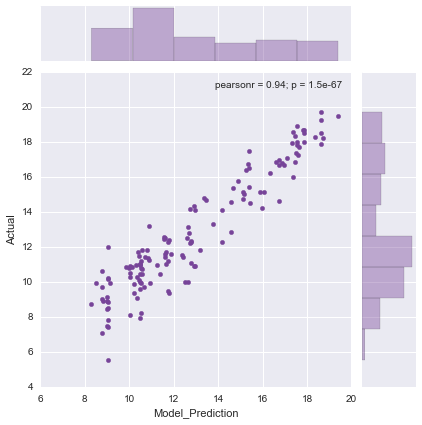

In [129]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,10))
sns.jointplot(x=results.Model_Prediction, y=results.Actual, color="#774499")

In [130]:
#wiki = sns.JointGrid(x=results.Model_Prediction, y=results.Actual,ratio=100)
#wiki.plot_joint(sns.regplot)

In [131]:
prediction, bias, contributions = ti.predict(reg, X_test)

In [230]:
for i in range(len(X_test)):
    print "Instance", i
    print "Bias (mean)", bias[i]
    print "Feature contributions:"
    for c, feature in sorted(zip(contributions[i], 
                               X_test.columns), 
                             key=lambda x: -abs(x[0])):
        print feature, round(c, 2)
    print "-"*20 

Instance 0
Bias (mean) 12.5581089138
Feature contributions:
TheaterNum -2.13
is_Monterey Media, Inc. -0.22
Wikicount -0.13
is_R -0.06
is_Unrated -0.01
is_Samuel Goldwyn 0.01
is_War Drama 0.01
RunTime 0.01
is_Focus World 0.0
is_First Run 0.0
is_Drama 0.0
is_Sci-Fi Thriller 0.0
is_Fantasy Comedy 0.0
is_Mongrel Media -0.0
is_Sky Island Films -0.0
is_Kino Lorber -0.0
is_Adventure -0.0
is_Strasson Group -0.0
is_Cohen Media Group -0.0
is_Q1 0.0
is_Q3 -0.0
is_Distrib Films 0.0
is_Orion Pictures 0.0
is_Sony / Columbia -0.0
is_Foreign 0.0
is_The Film Arcade 0.0
is_Independent 0.0
is_Documentary -0.0
is_IFC -0.0
is_Comedy / Drama 0.0
is_Gravitas Ventures -0.0
is_Paramount 0.0
is_Crime -0.0
is_Big World Pictures -0.0
is_Honorara Productions 0.0
is_CJ Entertainment -0.0
is_PG 0.0
is_Animation 0.0
is_Magnolia 0.0
is_Thriller 0.0
is_Action / Adventure -0.0
is_Film Movement -0.0
is_PG-13 0.0
is_Q4 -0.0
is_G 0.0
is_Not Yet Rated 0.0
is_Q2 0.0
is_Action 0.0
is_Action / Crime 0.0
is_Action Comedy 0.0
is

/Users/lemakikuchi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: order is deprecated, use sort_values(...)


[<matplotlib.text.Text at 0x120af6650>, <matplotlib.text.Text at 0x120ad8a50>]

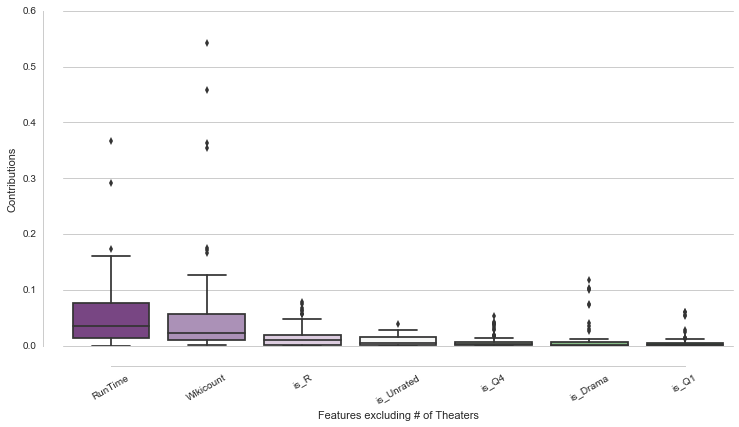

In [155]:
sns.set(style="ticks")
sns.set_style("whitegrid")


o = pd.DataFrame(abs(contributions))
#pd.pivot_table(o, aggfunc=np.sum, margins=True)
#o.sort_index(by=o.sum(), axis=1)
q = o.median(axis=0).order(ascending=False).head(8).index
p = o[q[1:]]
m = list(X_test)
labels = []
for n in p:
    labels.append(m[n])
plt.figure(figsize=(12,6))
o = sns.boxplot(p, palette="PRGn", showfliers=True)
sns.despine(offset=20, trim=True)
o.set_xticklabels(labels, rotation=30)
o.set(xlabel='Features excluding # of Theaters', ylabel='Contributions')

In [135]:
total = np.mean(contributions, axis=0) 

In [187]:
#for c, feature in sorted(zip(total, 
#                             X_test.columns), key=lambda x: -abs(x[0])):
#    print feature, round(c, 4)

In [137]:
q = reg.predict(X_test)

In [138]:
pd.options.display.float_format = '${:,.4f}'.format

In [139]:
np.exp(((q-Y_test)/Y_test).mean())

ValueError: operands could not be broadcast together with shapes (139,) (139,2) 

In [ ]:
pre = pd.Series(q)
act = pd.Series(Y_test).astype('float64', raise_on_error = False)

In [ ]:
print np.exp(pre), np.exp(act)

In [ ]:
np.exp(act[138:139])*0.26
#np.exp(p[138:139])

In [ ]:
np.exp(p[137:138])

In [ ]:
def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    for parameter,parameter_range in param_ranges.iteritems():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(5):
                X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size = .3)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
        ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')
        
        ax.set_xlabel(parameter)
        ax.set_ylabel('score')
        ax.legend(loc=0)

In [172]:
np.exp(Y_test)

,index,DomesticGross
0,"$1,112,863,754,791,759,440,048,804,931,959,783,...","$3,289.0000"
1,"$15,684,135,116,819,639,963,854,721,839,446,230...","$1,978,592.0000"
2,"$769,478,526,514,201,752,502,272.0000","$20,555.0000"
3,"$287,264,955,081,783,210,577,787,502,601,186,02...","$208,588.0000"
4,"$840,388,793,620,695,915,345,261,721,456,081,49...","$108,083.0000"
5,"$195,729,609,428.8388","$13,191.0000"
6,"$18,240,823,746,066,321,465,691,741,359,823,503...","$3,703,046.0000"
7,"$3,915,275,707,099,618,627,728,778,927,886,171,...","$17,766,658.0000"
8,"$107,242,959,451,989,176,055,998,209,915,302,94...","$6,980,524.0000"
9,"$1,040,792,726,430,430,019,274,350,853,564,022,...","$56,196.0000"


In [168]:
ok = X_test[129:130]

In [235]:
ok.set_value(577,'Wikicount', 2000000)
#ok.drop(['Theatercount'], axis=1, inplace=True)
ok

,is_G,is_Not Yet Rated,is_PG,is_PG-13,is_R,is_Unrated,is_Q1,is_Q2,is_Q3,is_Q4,...,is_Wingate Distribution,is_Wonder Vision,is_Yari Film Group,is_Yash Raj,is_Zeitgeist,is_Zell-Koj Studio,is_Zipporah Films,TheaterNum,RunTime,Wikicount
577,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,4300,$141.0000,2000000


In [236]:
np.exp(reg.predict(ok))[0]

251829221.80834967

In [ ]:
wlist = [100000, ]

In [ ]:
dlist = [120740235, ]

In [256]:
np.exp(Y_test)

,index,DomesticGross
0,"$1,112,863,754,791,759,440,048,804,931,959,783,...","$3,289.0000"
1,"$15,684,135,116,819,639,963,854,721,839,446,230...","$1,978,592.0000"
2,"$769,478,526,514,201,752,502,272.0000","$20,555.0000"
3,"$287,264,955,081,783,210,577,787,502,601,186,02...","$208,588.0000"
4,"$840,388,793,620,695,915,345,261,721,456,081,49...","$108,083.0000"
5,"$195,729,609,428.8388","$13,191.0000"
6,"$18,240,823,746,066,321,465,691,741,359,823,503...","$3,703,046.0000"
7,"$3,915,275,707,099,618,627,728,778,927,886,171,...","$17,766,658.0000"
8,"$107,242,959,451,989,176,055,998,209,915,302,94...","$6,980,524.0000"
9,"$1,040,792,726,430,430,019,274,350,853,564,022,...","$56,196.0000"


In [255]:
df_g[25:50]

,Title,DomesticGross,is_G,is_Not Yet Rated,is_PG,is_PG-13,is_R,is_Unrated,is_Q1,is_Q2,...,is_Wingate Distribution,is_Wonder Vision,is_Yari Film Group,is_Yash Raj,is_Zeitgeist,is_Zell-Koj Studio,is_Zipporah Films,TheaterNum,RunTime,Wikicount
122,Creed,109767581,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$0.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,3502,$133.0000,41952
506,The Angry Birds Movie,107509366,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$0.0000,$1.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,3932,$97.0000,390288
245,Independence Day: Resurgence,103144286,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$1.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,4130,$120.0000,1174526
524,The Conjuring 2,102470008,$0.0000,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$1.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,3356,$134.0000,1005403
429,Ride Along 2,90862685,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$1.0000,$0.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,3192,$101.0000,140823
461,Sisters,87044645,$0.0000,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,2978,$118.0000,6610
32,Alvin and the Chipmunks: The Road Chip,85886987,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,3705,$86.0000,164541
500,Teenage Mutant Ninja Turtles: Out of the Shadows,82051601,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$1.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,4071,$112.0000,8419
315,Maze Runner: The Scorch Trials,81697192,$0.0000,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$0.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,3792,$131.0000,573862
204,Goosebumps,80080379,$0.0000,$0.0000,$1.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,...,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,$0.0000,3618,$103.0000,118745


In [249]:
ok.ix[:,208:209]

,Wikicount
577,2000000
